<a href="https://colab.research.google.com/github/shjoo0407/political_disposition/blob/main/eun/TopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/2023/sw공모전

/content/drive/MyDrive/2023/sw공모전


In [2]:
# # 형태소 분석기 Mecab 설치
# !pip install konlpy
# !pip install mecab-python
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [3]:
import pandas as pd
from konlpy.tag import Mecab
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import numpy as np

### data load

In [30]:
import pandas as pd

def data(startY, startQ, endY, endQ, type):
    '''
    startY: 임기시작 년도, startQ: 임기시작 년도의 분기
    endY: 임기종료 년도, endQ: 임기종료 년도의 분기
    '''

    if type == 'all':
      df1 = pd.read_csv('data/NPP_final_0729.csv', sep=',')
      df2 = pd.read_csv('data/TMP_final_0729.csv', sep=',')

      df1['target'] = '국민의힘'
      df2['target'] = '민주당'

      df = pd.concat([df1, df2]).reset_index()
    elif type == 'npp':
      df = pd.read_csv('data/NPP_final_0729.csv', sep=',')
      df['target'] = '국민의힘'
    else:
      df = pd.read_csv('data/TMP_final_0729.csv', sep=',')
      df['target'] = '민주당'


    df = df[(df['year'] > startY) | ((df['year'] == startY) & (df['quarter'] >= startQ))]
    df = df[(df['year'] < endY) | ((df['year'] == endY) & (df['quarter'] <= endQ))]

    df = df[['content', 'target']]
    df = df.dropna()



    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Example usage:
start_year = 2022
start_quarter = 2
end_year = 2023
end_quarter = 3
data_type = 'all'

df = data(start_year, start_quarter, end_year, end_quarter, data_type)
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target
0,‘빗물을 나르는 고속도로’라 불리는 대심도 빗물터널 조금 전에 둘러보고 왔다. 신월...,국민의힘
1,"오늘 한 언론에 보도된 무소속 박완주 의원의 검찰 공소장 안에는, 강력 성범죄자의 ...",국민의힘
2,전국적인 집중호우로 많은 국민들이 희생되고 막대한 재산 피해가 발생했다. 당장 전면...,국민의힘
3,더불어민주당이 윤석열 정부의 ‘시행령 추진’에 본격적으로 제동을 걸고 있다. KBS...,국민의힘
4,"그칠 줄 모르던 비가 잠시 소강상태에 접어들었지만, 폭우가 할퀴고 간 자리에 남겨진...",국민의힘


In [56]:
print(df[df['target']=='국민의힘'].shape)
print(df[df['target']=='민주당'].shape)
print(df.shape)

(3733, 2)
(3659, 2)
(7392, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### preprocessing

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [11]:
komoran = Komoran()
hannanum = Hannanum()

In [12]:
#불용어 사전 만들기
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [13]:
# 정규화
def preprocess(text):
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def final(text):
    n = []
    word = komoran.nouns(text)
    p = komoran.pos(text)
    for pos in p:
      if pos[1] in ['SL']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return final(preprocess(text))


In [58]:
df['content2'] = df['content'].apply(lambda x: finalpreprocess(x))
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,content2
40452,"정체불명의 해외발 우편물, 국민 불안이 확산되는데 정부는 손놓고 있습니까 3일째 전...",민주당,정체 불명 해외 우편물 국민 불안 확산 정부 전국 곳곳 해외 발송 정체 불명 우편물...
40453,검찰은 조작 수사도 모자라 이제는 진술을 왜곡해 언론에 퍼뜨려 여론을 호도하고 있습...,민주당,검찰 조작 수사 이제 진술 왜곡 언론 여론 호도 최근 이화영 경기도 평화 부지사 그...
40454,윤석열 대통령은 높아지는 군사적 긴장에 언제까지 팔짱만 끼고 있을 겁니까 북한이 오...,민주당,윤석열 대통령 군사 긴장 팔짱 북한 오늘 새벽 서해 순항 미사일 발사 북한 무력 도...
40455,국정 운영 방향을 남 탓으로 정한 정권은 윤석열 정권뿐입니다 “윤 대통령의 국정 운...,민주당,국정 운영 방향 정권 윤석열 정권 대통령 국정 운영 방향 좌파 정권 동안 대한민국 ...
40456,"누구보다 나라를 사랑했던 청년, 명령에 충실했던 병사를 기억하겠습니다 경북 예천에서...",민주당,나라 사랑 청년 명령 충실 병사 기억 경북 예천 실종자 수색 순직 채수 상병 영결식...


In [57]:
df = df[df['target']=='민주당']
print(df.shape)

(3659, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### topic modeling

In [59]:
df['content3'] = df['content2'].str.split(" ")
df= df.drop(df[df['content3'].apply(lambda x: isinstance(x, float))].index)
df.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,content2,content3
40452,"정체불명의 해외발 우편물, 국민 불안이 확산되는데 정부는 손놓고 있습니까 3일째 전...",민주당,정체 불명 해외 우편물 국민 불안 확산 정부 전국 곳곳 해외 발송 정체 불명 우편물...,"[정체, 불명, 해외, 우편물, 국민, 불안, 확산, 정부, 전국, 곳곳, 해외, ..."
40453,검찰은 조작 수사도 모자라 이제는 진술을 왜곡해 언론에 퍼뜨려 여론을 호도하고 있습...,민주당,검찰 조작 수사 이제 진술 왜곡 언론 여론 호도 최근 이화영 경기도 평화 부지사 그...,"[검찰, 조작, 수사, 이제, 진술, 왜곡, 언론, 여론, 호도, 최근, 이화영, ..."
40454,윤석열 대통령은 높아지는 군사적 긴장에 언제까지 팔짱만 끼고 있을 겁니까 북한이 오...,민주당,윤석열 대통령 군사 긴장 팔짱 북한 오늘 새벽 서해 순항 미사일 발사 북한 무력 도...,"[윤석열, 대통령, 군사, 긴장, 팔짱, 북한, 오늘, 새벽, 서해, 순항, 미사일..."


In [60]:
data_word = df['content3']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install pyLDAvis

In [17]:
from gensim import corpora
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=10):
    coherence_values = []
    perplexity_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))


    return model_list, coherence_values, perplexity_values


def find_optimal_number_of_topics(dictionary, corpus, processed_data, step, start, limit):
    model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)

    # Plot Coherence Score
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, coherence_values, label='Coherence')
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence Score")

    # Plot Perplexity Score
    plt.subplot(1, 2, 2)
    plt.plot(x, perplexity_values, label='Perplexity')
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity Score")

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
# 정수 인코딩과 빈도수 생성
dictionary = corpora.Dictionary(data_word)

# 출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below=10, no_above=0.05)
corpus = [dictionary.doc2bow(text) for text in data_word]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique tokens: 3530
Number of documents: 3659


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


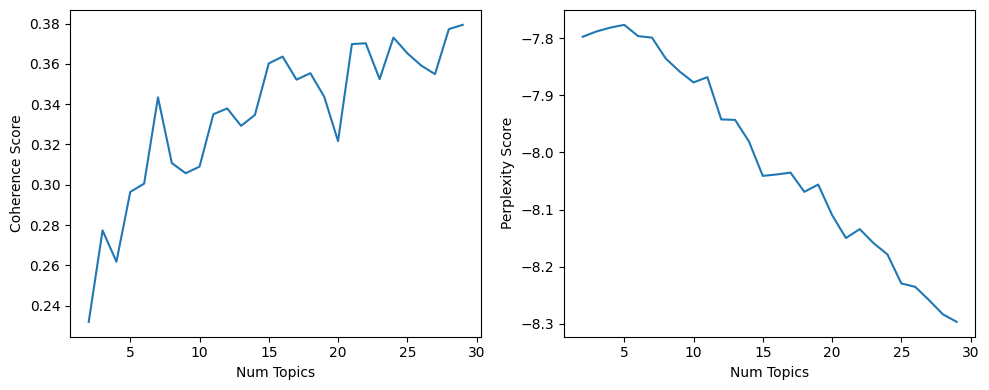

In [62]:
# 최적의 토픽 수 찾기
find_optimal_number_of_topics(dictionary, corpus, data_word, 1, 2, 30)

In [21]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
coherence_logger = CoherenceMetric(corpus=corpus, coherence="u_mass", logger='shell')

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=14, passes=100, callbacks=[coherence_logger, perplexity_logger])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_word, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (c_v): ', coherence_lda)

# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_word, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (u_mass): ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score (c_v):  0.4652031454852656

Coherence Score (u_mass):  -5.072128277367265


In [65]:
# 정수 인코딩과 빈도수 생성
dictionary = corpora.Dictionary(data_word)

# 출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below=10, no_above=0.05)
corpus = [dictionary.doc2bow(text) for text in data_word]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique tokens: 3530
Number of documents: 3659


In [66]:
import pandas as pd

num_topics = 14
topic_words_list = []

for topic_id in range(num_topics):
    topic_words = lda_model.show_topic(topic_id)
    words = [word for word, _ in topic_words]
    topic_words_list.append({'Topic ID': topic_id + 1, 'Words': words})

# topic_words_list 리스트를 바탕으로 DataFrame 생성
keyword_newsdf = pd.DataFrame(topic_words_list, columns=['Topic ID', 'Words'])

print(keyword_newsdf)

    Topic ID                                            Words
0          1       [대전, 보건, 복지부, 강원도, 대구, 의료, 복지, 건강, 강원, 공약]
1          2    [감사원, 장악, 방송, 독립, 국정원, 법무부, 시행령, 보복, 중립, 공화국]
2          3        [물가, 공인, 소상, 에너지, 금융, 서민, 인상, 부담, 부자, 극복]
3          4  [교육, 교육부, 김은혜, 변경, 혼란, 고속도로, 원희룡, 경호, 국토부, 박순애]
4          5     [유가족, 이상민, 재난, 희생자, 용산, 욕설, 산불, 유족, 거짓말, 안부]
5          6    [공천, 당선자, 한동훈, 자료, 비서관, 법무부, 징계, 이준석, 제출, 공직]
6          7     [한반도, 강제, 도발, 평화, 피해자, 한일, 군사, 정상회담, 중국, 굴종]
7          8       [청년, 투표, 여성, 일꾼, 희망, 구청장, 당선, 발전, 해주시, 존경]
8          9   [원내대표, 권성동, 여야, 파업, 협상, 법안, 대화, 화물, 김문수, 화물연대]
9         10        [노동, 선인, 특보, 노조, 인천, 이동관, 농민, 개혁, 폭력, 방송]
10        11      [관저, 민영화, 집무실, 뉴스, 공약, 가짜, 공사, 오세훈, 용산, 혈세]
11        12  [후쿠시마, 방류, 방역, 해양, 원전, IAEA, 방사능, 수산물, 보고서, 과학]
12        13       [김기현, 총리, 막말, 한덕수, 채용, 극우, 내각, 대회, 전당, 수석]
13        14    [특검, 조작, 압수수색, 증거, 주가조작, 대장동, 범죄, 기소, 진술, 소환]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
import pyLDAvis.gensim

lda_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_visualization, 'topic_modeling3.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
ls

 data/                   'df(윤석렬).csv'       TopicModeling.ipynb
'df(preprocessing).csv'   topic_modeling.html


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
